In [359]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and optimization imports
import optuna
import shap
from sklearn.preprocessing import (LabelBinarizer, OneHotEncoder, StandardScaler,
                                 OrdinalEncoder, RobustScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import AdaBoostClassifier

# Gradient Boosting implementations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Set pandas display options for better readability
pd.set_option('display.max_columns', 0)

In [360]:
# Pandas display options
pd.set_option('display.max_columns', 0)


## ASNA Hackathon Submission Notebook

### Introduction

In this notebook, we tackle the challenge of predicting auto insurance claims using machine learning. The goal is to develop a robust model that can accurately predict whether a customer will file a claim over $1,000, which is crucial for insurance companies to assess risk and optimize their business strategies.

Our approach involves:
1. Comprehensive data exploration and feature engineering
2. Implementation of various machine learning models including LightGBM, XGBoost, and CatBoost
4. Ensemble methods to improve prediction accuracy
5. Detailed model evaluation and interpretation

The dataset contains 29 features including customer demographics, policy details, and historical information, providing a rich foundation for building predictive models. Through careful analysis and modeling, we aim to provide valuable insights for insurance risk assessment and customer management.

### Data Cleaning

In [361]:
# Define file paths
TRAIN_DATA_PATH = '../data/train.csv'
TEST_DATA_PATH = '../data/test.csv'
SUBMISSION_PATH = '../data/submission.csv'

# Read the data
df = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

# Display dataset shapes
print("Training data shape:", df.shape)
print("Test data shape:", df_test.shape)

Training data shape: (7290, 29)
Test data shape: (1844, 28)


In [362]:
# Display first few rows of training data
print("\nFirst few rows of training data:")
display(df.head())

# Display first few rows of training data
print("\nFirst few rows of test data:")
display(df_test.head())


First few rows of training data:


,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index,Claim over 1k
0,QC35222,California,3622.69,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,F,65163,Married,1,4,107,3,1,Corporate Auto,1,Corporate L2,4,3,Web,0,Medsize,1,0
1,AE98193,Washington,10610.21,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,M,0,Single,0,26,14,0,7,Personal Auto,0,Personal L1,0,1,Branch,1,Medsize,1,1
2,TM23514,Oregon,13868.02,No,Extended,1,College,1,1/1/2024,Employed,1,M,81196,Single,0,11,38,0,3,Personal Auto,0,Personal L3,2,3,Web,0,Medsize,1,0
3,QZ42725,Washington,3119.69,No,Basic,0,Bachelor,2,1/1/2024,Unemployed,0,F,0,Single,0,16,32,0,1,Personal Auto,0,Personal L3,2,2,Agent,2,Medsize,1,0
4,SG81493,Arizona,5999.04,No,Premium,2,Bachelor,2,1/1/2024,Employed,1,M,62618,Married,1,45,126,0,1,Corporate Auto,1,Corporate L1,3,2,Web,0,Medsize,1,0



First few rows of test data:


,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index
0,WB38524,California,4008.95,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,M,62277,Married,1,36,38,0,1,Personal Auto,0,Personal L3,2,2,Branch,1,Small,0
1,QP80741,Washington,8165.58,No,Basic,0,College,1,1/1/2024,Unemployed,0,F,0,Married,1,23,96,3,2,Corporate Auto,1,Corporate L1,3,3,Agent,2,Medsize,1
2,WP41146,California,7210.94,No,Basic,0,High School or Below,0,1/1/2024,Unemployed,0,F,0,Married,1,5,15,1,7,Personal Auto,0,Personal L2,1,1,Branch,1,Medsize,1
3,KR62797,Arizona,6198.70,No,Basic,0,High School or Below,0,1/1/2024,Employed,1,F,112451,Married,1,8,38,0,1,Personal Auto,0,Personal L2,1,2,Call Center,3,Medsize,1
4,VE55982,Nevada,3570.32,No,Basic,0,Bachelor,2,1/1/2024,Employed,1,M,72900,Divorced,2,20,61,0,1,Corporate Auto,1,Corporate L1,3,1,Call Center,3,Medsize,1


In [363]:
# Display basic information about the datasets
print("\nTraining data info:")
display(df.info())

print("\nTest data info:")
display(df_test.info())


Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     7290 non-null   object 
 1   State                          7290 non-null   object 
 2   Customer Lifetime Value        7290 non-null   float64
 3   Response                       7290 non-null   object 
 4   Coverage                       7290 non-null   object 
 5   Coverage Index                 7290 non-null   int64  
 6   Education                      7290 non-null   object 
 7   Education Index                7290 non-null   int64  
 8   Effective To Date              7290 non-null   object 
 9   Employment Status              7290 non-null   object 
 10  Employment Status Index        7290 non-null   int64  
 11  Gender                         7290 non-null   object 
 12  Income                     

None


Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844 entries, 0 to 1843
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     1844 non-null   object 
 1   State                          1844 non-null   object 
 2   Customer Lifetime Value        1844 non-null   float64
 3   Response                       1844 non-null   object 
 4   Coverage                       1844 non-null   object 
 5   Coverage Index                 1844 non-null   int64  
 6   Education                      1844 non-null   object 
 7   Education Index                1844 non-null   int64  
 8   Effective To Date              1844 non-null   object 
 9   Employment Status              1844 non-null   object 
 10  Employment Status Index        1844 non-null   int64  
 11  Gender                         1844 non-null   object 
 12  Income                         

None

In [364]:
# Check for missing values
print("\nMissing values in training data:")
display(df.isnull().sum())

print("\nMissing values in test data:")
display(df_test.isnull().sum())


Missing values in training data:


CustomerID                       0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Coverage Index                   0
Education                        0
Education Index                  0
Effective To Date                0
Employment Status                0
Employment Status Index          0
Gender                           0
Income                           0
Marital Status                   0
Marital Status Index             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy Type Index                0
Policy                           0
Policy Index                     0
Renew Offer Type                 0
Sales Channel                    0
Sales Channel Index              0
Vehicle Size                     0
Vehicle Size Index               0
Claim over 1k       


Missing values in test data:


CustomerID                       0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Coverage Index                   0
Education                        0
Education Index                  0
Effective To Date                0
Employment Status                0
Employment Status Index          0
Gender                           0
Income                           0
Marital Status                   0
Marital Status Index             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy Type Index                0
Policy                           0
Policy Index                     0
Renew Offer Type                 0
Sales Channel                    0
Sales Channel Index              0
Vehicle Size                     0
Vehicle Size Index               0
dtype: int64

In [365]:
# Convert datetime features
df['Effective To Date'] = df['Effective To Date'].astype('datetime64[ns]')
df_test['Effective To Date'] = df_test['Effective To Date'].astype('datetime64[ns]')

In [366]:
# Check for number of unique values
print("\nNumber of unique values in training data")
display(df.nunique())

print("\nNumber of unique values in test data")
display(df_test.nunique())


Number of unique values in training data


CustomerID                       7290
State                               5
Customer Lifetime Value          6464
Response                            2
Coverage                            3
Coverage Index                      3
Education                           5
Education Index                     5
Effective To Date                  59
Employment Status                   5
Employment Status Index             5
Gender                              2
Income                           4621
Marital Status                      3
Marital Status Index                3
Months Since Last Claim            36
Months Since Policy Inception     100
Number of Open Complaints           6
Number of Policies                  9
Policy Type                         3
Policy Type Index                   3
Policy                              9
Policy Index                        9
Renew Offer Type                    4
Sales Channel                       4
Sales Channel Index                 4
Vehicle Size


Number of unique values in test data


CustomerID                       1844
State                               5
Customer Lifetime Value          1729
Response                            2
Coverage                            3
Coverage Index                      3
Education                           5
Education Index                     5
Effective To Date                  59
Employment Status                   5
Employment Status Index             5
Gender                              2
Income                           1286
Marital Status                      3
Marital Status Index                3
Months Since Last Claim            36
Months Since Policy Inception     100
Number of Open Complaints           6
Number of Policies                  9
Policy Type                         3
Policy Type Index                   3
Policy                              9
Policy Index                        9
Renew Offer Type                    4
Sales Channel                       4
Sales Channel Index                 4
Vehicle Size

### Exploratory Data Analysis

In [367]:
# Basic descriptive statistics
df.describe()

,Customer Lifetime Value,Coverage Index,Education Index,Effective To Date,Employment Status Index,Income,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type Index,Policy Index,Renew Offer Type,Sales Channel Index,Vehicle Size Index,Claim over 1k
count,7290.000000,7290.000000,7290.000000,7290,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000,7290.000000
mean,10798.116623,0.490261,1.287243,2016-07-01 12:44:02.962962944,0.985597,50573.282579,0.878189,20.514678,65.164335,0.379287,2.978875,0.300000,2.216735,1.964472,1.622497,0.913717,0.114129
min,2562.310000,0.000000,0.000000,2011-01-13 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5374.027500,0.000000,0.000000,2011-01-27 00:00:00,0.000000,0.000000,0.000000,8.000000,32.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
50%,7845.015000,0.000000,1.000000,2011-02-23 00:00:00,1.000000,45398.500000,1.000000,19.000000,65.000000,0.000000,2.000000,0.000000,2.000000,2.000000,2.000000,1.000000,0.000000
75%,12152.585000,1.000000,2.000000,2024-05-01 00:00:00,1.000000,83655.750000,1.000000,31.000000,96.000000,0.000000,4.000000,1.000000,3.000000,3.000000,2.000000,1.000000,0.000000
max,100208.500000,2.000000,4.000000,2024-12-02 00:00:00,4.000000,134947.000000,2.000000,47.000000,134.000000,5.000000,9.000000,2.000000,8.000000,4.000000,3.000000,2.000000,1.000000
std,9180.878153,0.658827,1.079150,NaN,0.910412,41090.968142,0.638740,13.626412,37.656121,0.903361,2.404229,0.543978,1.785506,1.004708,0.956533,0.534543,0.317990


In [368]:
df.describe(include = 'O')

,CustomerID,State,Response,Coverage,Education,Employment Status,Gender,Marital Status,Policy Type,Policy,Sales Channel,Vehicle Size
count,7290,7290,7290,7290,7290,7290,7290,7290,7290,7290,7290,7290
unique,7290,5,2,3,5,5,2,3,3,9,4,3
top,QC35222,California,No,Basic,Bachelor,Employed,F,Married,Personal Auto,Personal L3,Agent,Medsize
freq,1,2520,6265,4387,2175,4536,3711,4208,5416,2741,2783,5153


In [369]:
# Split columns into numerical and categorical
num_cols = ['Customer Lifetime Value', 'Income', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies']
cat_cols = ['Coverage']

### Claims over 1k

<Axes: xlabel='Claim over 1k', ylabel='count'>

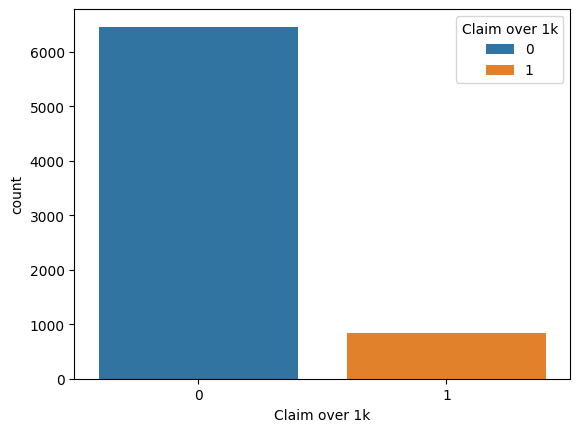

In [370]:
sns.countplot(data = df, x = 'Claim over 1k', hue = 'Claim over 1k')

We note that the target is a bit imbalanced and so we will some techniques in order to address this issue

### Numerical Variables

### Customer Lifetime Value (CLV)

<Axes: xlabel='Customer Lifetime Value'>

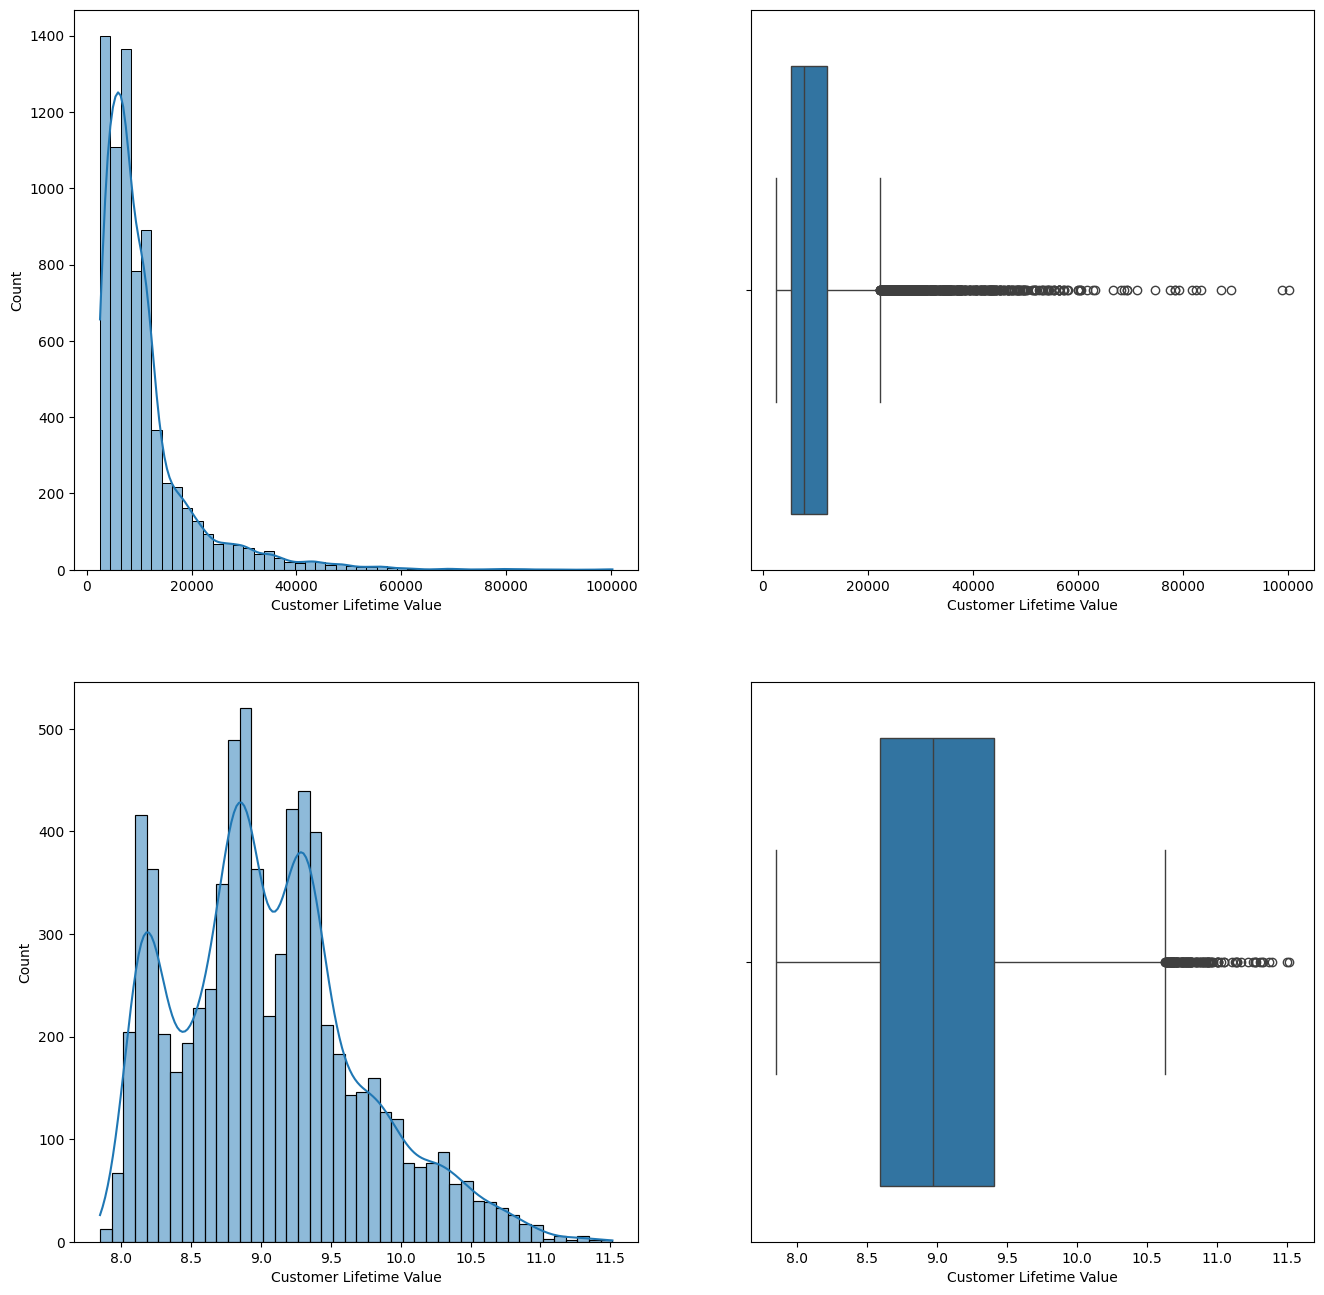

In [371]:
plt.figure(figsize = (16,16))

plt.subplot(2,2,1)
sns.histplot(data = df, x = 'Customer Lifetime Value', bins = 50, kde = True)

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Customer Lifetime Value')

plt.subplot(2,2,3)
sns.histplot(x = np.log(1 + df['Customer Lifetime Value']), kde = True)

plt.subplot(2,2,4)
sns.boxplot(x = np.log(1 + df['Customer Lifetime Value']))

### 

### CLV & Employment

<Axes: title={'center': 'Income'}, xlabel='Customer Lifetime Value', ylabel='Count'>

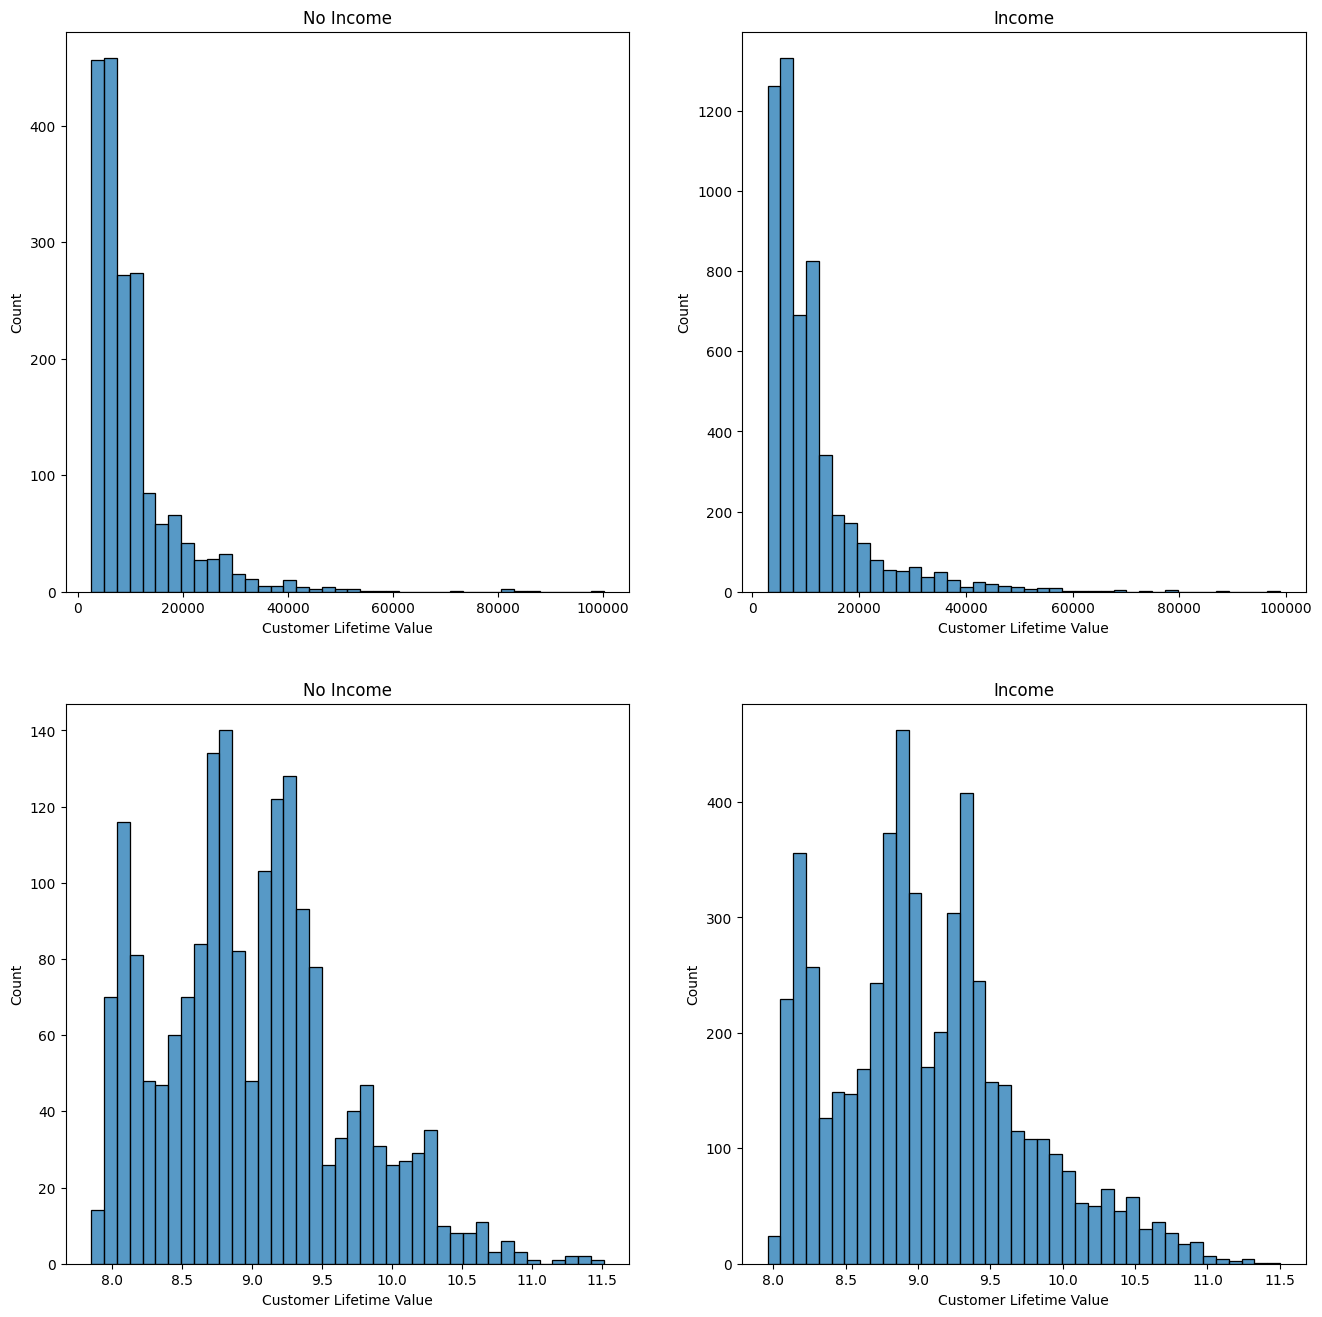

In [372]:
plt.figure(figsize = (16,16))

plt.subplot(2,2,1)
plt.title('No Income')
sns.histplot(data = df[df['Income'] == 0], x = 'Customer Lifetime Value', bins = 40)

plt.subplot(2,2,2)
plt.title('Income')
sns.histplot(data = df[df['Income'] > 0], x = 'Customer Lifetime Value', bins = 40)

plt.subplot(2,2,3)
plt.title('No Income')
sns.histplot(x = np.log(1 + df[df['Income'] == 0]['Customer Lifetime Value']), bins = 40)

plt.subplot(2,2,4)
plt.title('Income')
sns.histplot(x = np.log(1 + df[df['Income'] > 0]['Customer Lifetime Value']), bins = 40)

### Income

<Axes: xlabel='Income'>

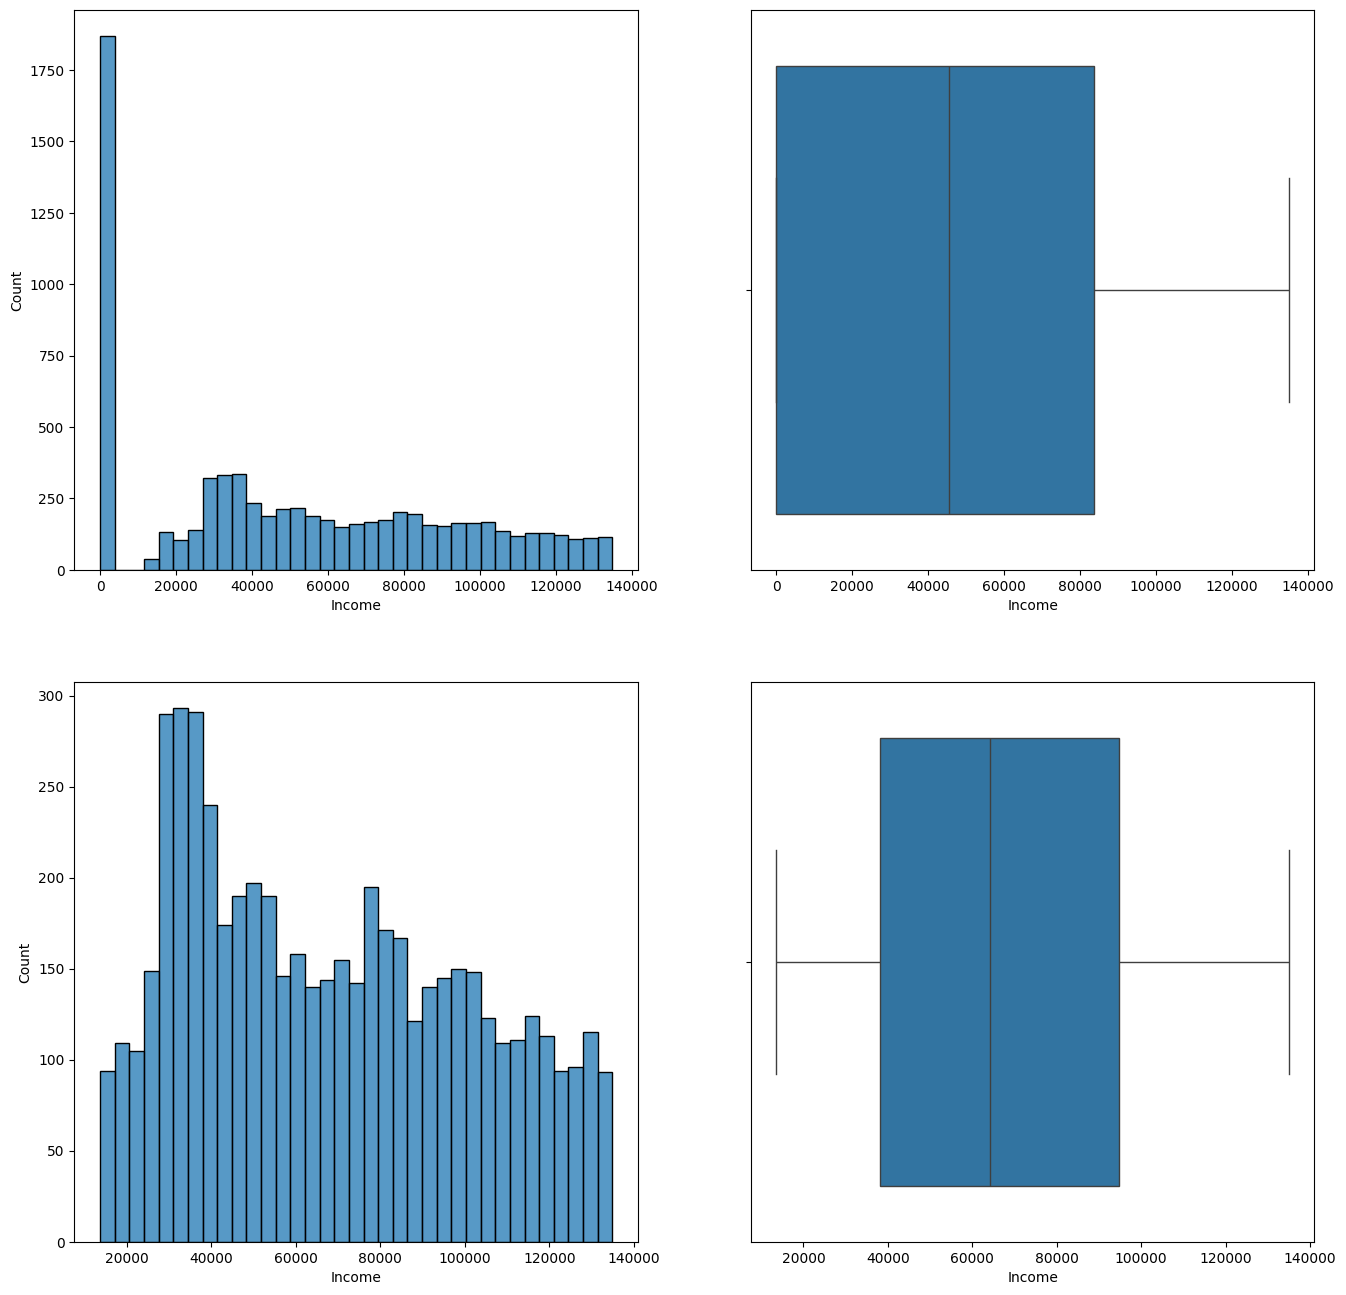

In [373]:
plt.figure(figsize = (16,16))

plt.subplot(2,2,1)
sns.histplot(data = df, x = 'Income', bins = 35)

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Income')

plt.subplot(2,2,3)
sns.histplot(x = df.loc[df['Income'] > 0, 'Income'], bins = 35)

plt.subplot(2,2,4)
sns.boxplot(x = df.loc[df['Income'] > 0, 'Income'])

### Months Since Last Claim

<Axes: xlabel='Months Since Last Claim', ylabel='Count'>

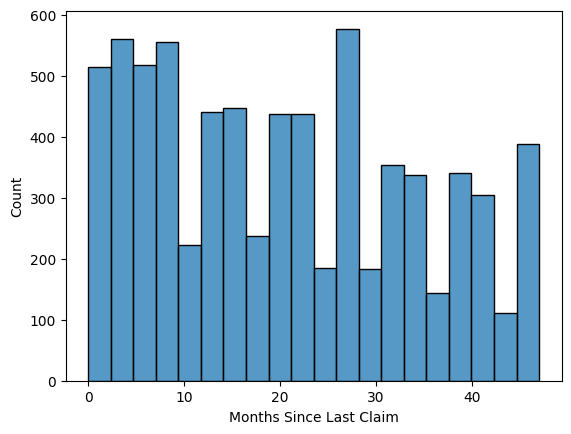

In [374]:
sns.histplot(data = df, x = 'Months Since Last Claim', bins = 20)

<Axes: xlabel='Months Since Policy Inception', ylabel='Count'>

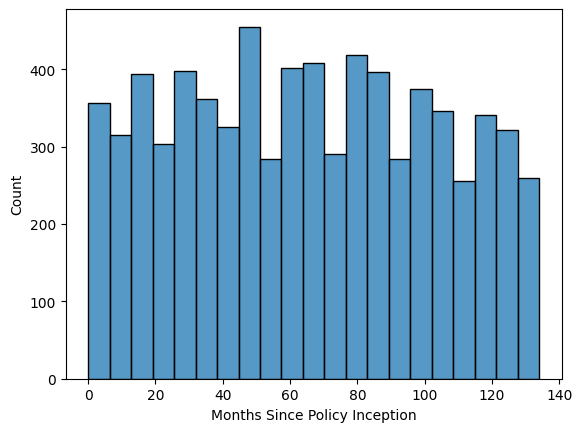

In [375]:
sns.histplot(data = df, x = 'Months Since Policy Inception')

### Number of Open Complaints & Policies

<Axes: xlabel='Number of Policies', ylabel='count'>

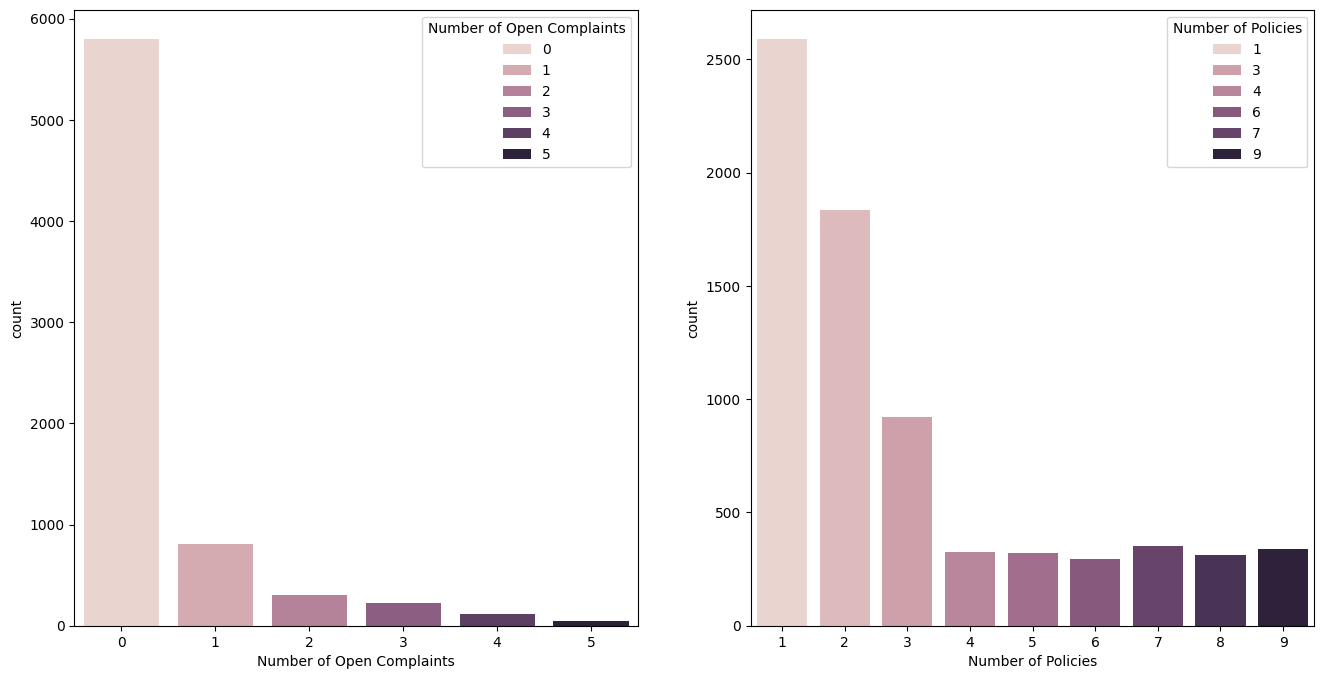

In [376]:
plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
sns.countplot(data = df, x = 'Number of Open Complaints', hue = 'Number of Open Complaints')

plt.subplot(1,2,2)
sns.countplot(data = df, x = 'Number of Policies', hue = 'Number of Policies')

<Axes: >

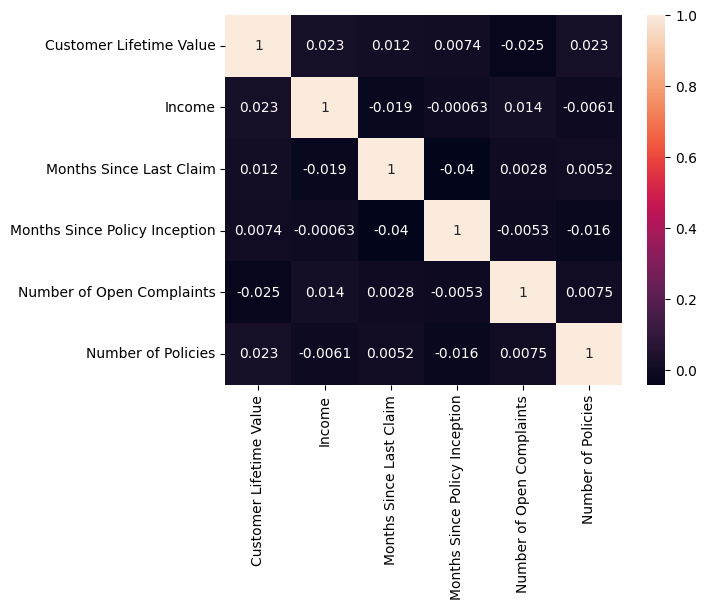

In [377]:
sns.heatmap(df[num_cols].corr(), annot = True)

### Categorical Variables

### Response

<Axes: xlabel='Response', ylabel='count'>

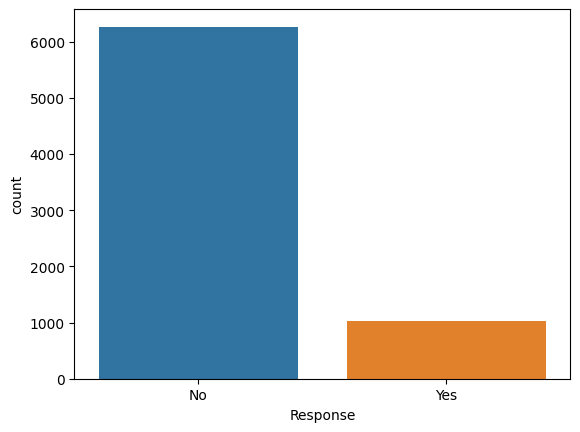

In [378]:
sns.countplot(data = df, x = 'Response', hue = 'Response')

### States

<Axes: xlabel='State', ylabel='count'>

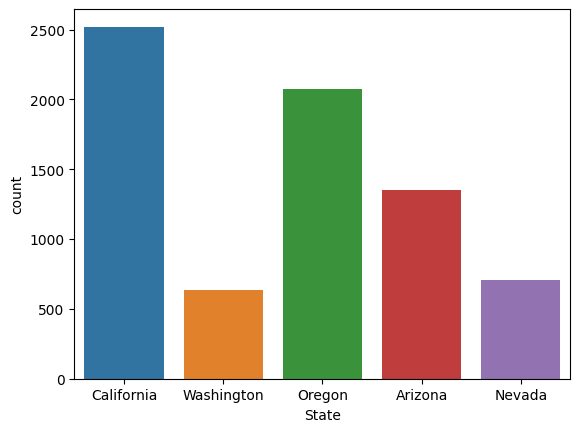

In [379]:
# States
sns.countplot(data = df, x = 'State', hue = 'State')

### Marital Status

<Axes: xlabel='Coverage', ylabel='count'>

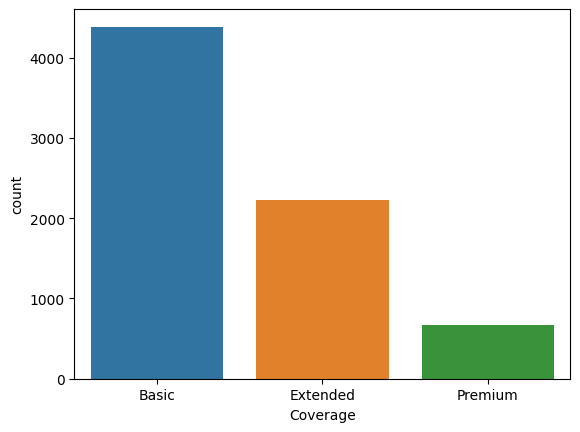

In [380]:
# Marital Status
sns.countplot(data = df, x = 'Coverage', hue = 'Coverage')

### Education

<Axes: xlabel='Education', ylabel='count'>

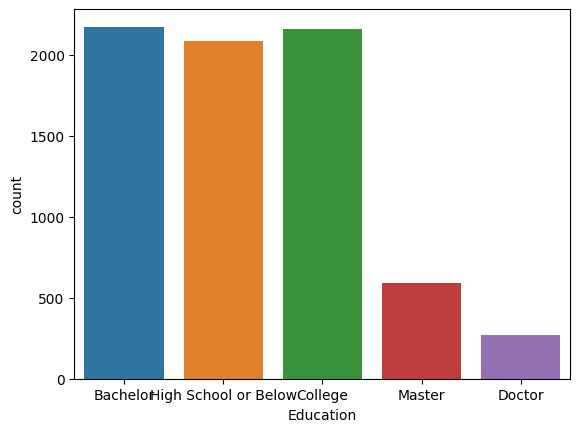

In [381]:
# Education 
sns.countplot(data = df, x = 'Education', hue = 'Education')

### Employment Status

<Axes: xlabel='Employment Status', ylabel='count'>

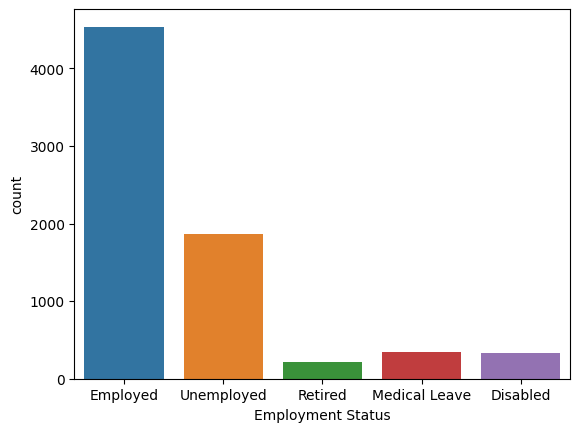

In [382]:
# Employment status
sns.countplot(data = df, x = 'Employment Status', hue = 'Employment Status')

### Gender

<Axes: xlabel='Gender', ylabel='count'>

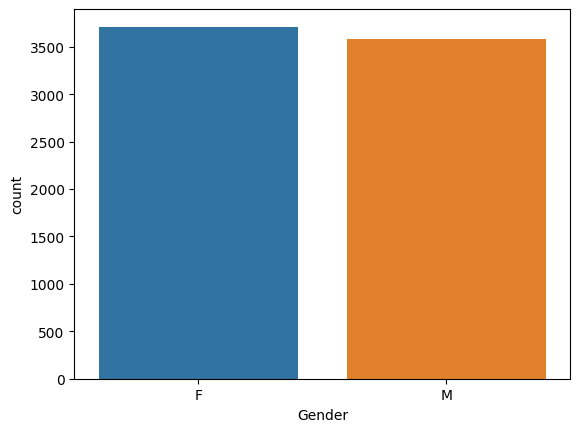

In [383]:
sns.countplot(data = df, x = 'Gender', hue = 'Gender')

### Marital Status

<Axes: xlabel='Marital Status', ylabel='count'>

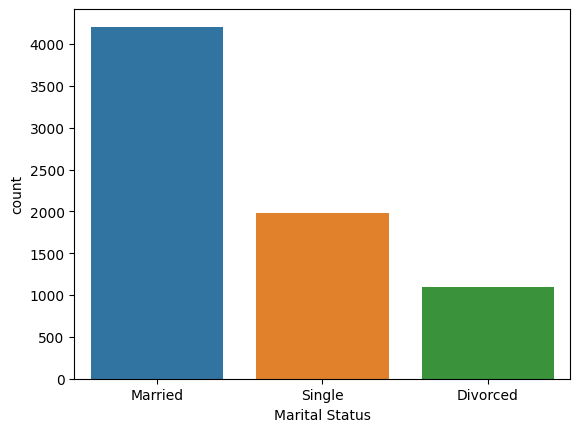

In [384]:
sns.countplot(data = df, x = 'Marital Status', hue = 'Marital Status')

### Policy Type & Policies

<Axes: xlabel='Policy Type', ylabel='count'>

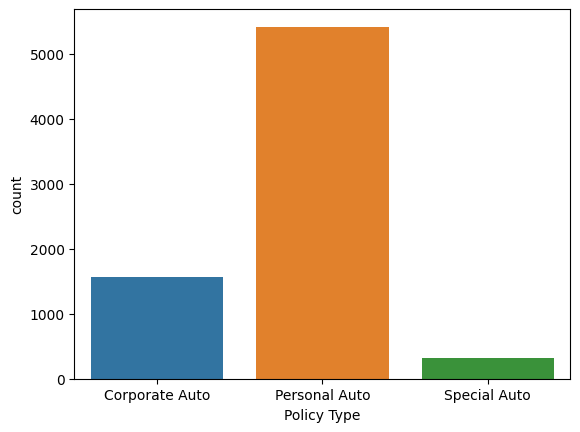

In [385]:
sns.countplot(data = df, x = 'Policy Type', hue = "Policy Type")

<Axes: xlabel='Policy Type', ylabel='count'>

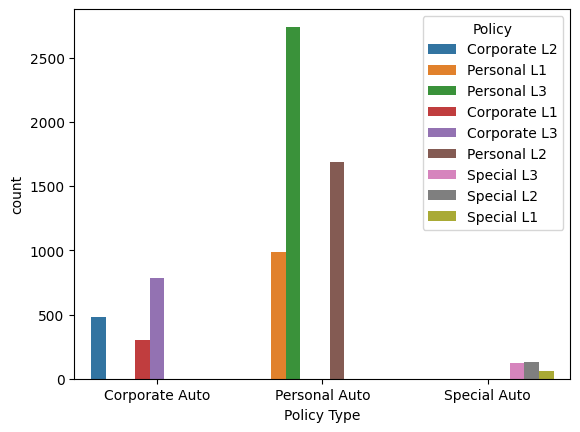

In [386]:
sns.countplot(data = df, x = 'Policy Type', hue = 'Policy')

### Renew Offer Type

<Axes: xlabel='Renew Offer Type', ylabel='count'>

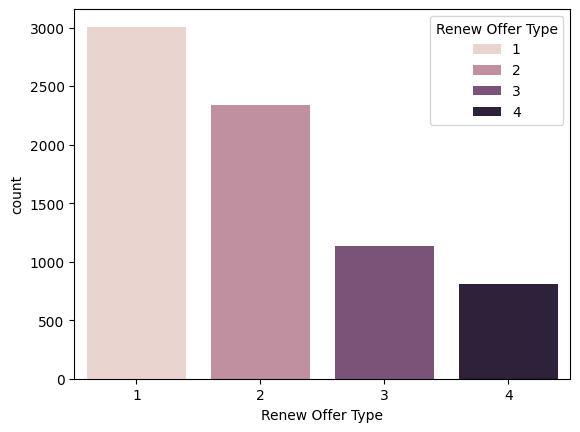

In [387]:
sns.countplot(data = df, x = 'Renew Offer Type', hue = 'Renew Offer Type')

### Sales Channel


<Axes: xlabel='Sales Channel', ylabel='count'>

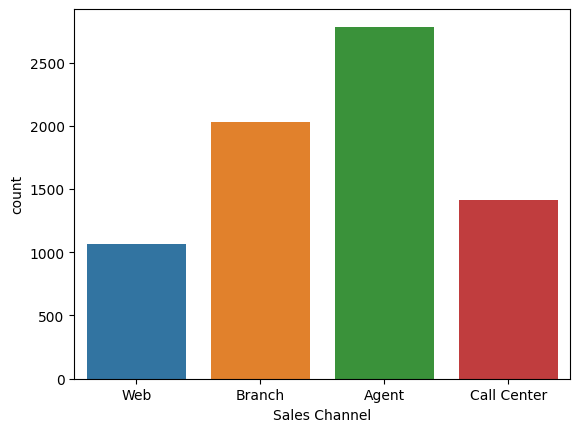

In [388]:
sns.countplot(data = df, x = 'Sales Channel', hue = 'Sales Channel')

### Vehicle Type

<Axes: xlabel='Vehicle Size', ylabel='count'>

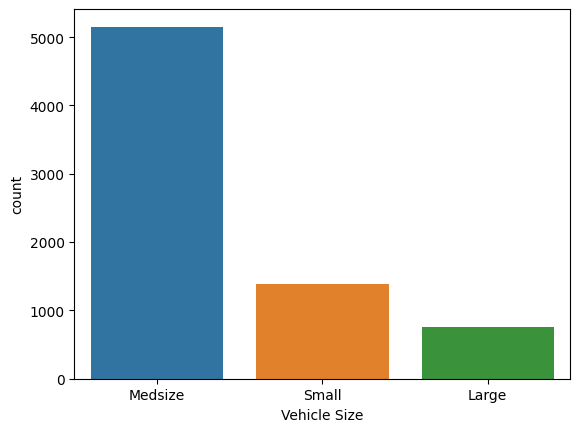

In [389]:
sns.countplot(data = df, x = 'Vehicle Size', hue = 'Vehicle Size')

## Data Preprocessing 

### Modify Features for Policy

We note that the feature `Policy` contains information about the policy type, which is already stored in `Policy Type`.

As a result, there are 9 unique values in this column, when it is supposed to be 3.

As such, we can save only the policy level such as `L1`, `L2`, and `L3`, in order to retain all of our information, whilst reducing the cardinality down to 3.

In [390]:
# Reduce High-cardinality variables
policy_type = {'Corporate Auto' : 'Corporate', 'Personal Auto' : 'Personal', 'Special Auto' : 'Special'}
policy = {'Corporate L1' : 'L1', 'Corporate L2' : 'L2', 'Corporate L3' : 'L3',
          'Personal L1' : 'L1', 'Personal L2' : 'L2', 'Personal L3' : 'L3',
          'Special L1' : 'L1', 'Special L2' : 'L2', 'Special L3' : 'L3'}

# Perform transformation on train dataset
df['Policy Type'] = df['Policy Type'].replace(policy_type)
df['Policy Index'] = df['Policy'].replace(policy)
df

,CustomerID,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Employment Status Index,Gender,Income,Marital Status,Marital Status Index,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy Type Index,Policy,Policy Index,Renew Offer Type,Sales Channel,Sales Channel Index,Vehicle Size,Vehicle Size Index,Claim over 1k
0,QC35222,California,3622.69,No,Basic,0,Bachelor,2,2024-01-01,Employed,1,F,65163,Married,1,4,107,3,1,Corporate,1,Corporate L2,L2,3,Web,0,Medsize,1,0
1,AE98193,Washington,10610.21,No,Basic,0,High School or Below,0,2024-01-01,Unemployed,0,M,0,Single,0,26,14,0,7,Personal,0,Personal L1,L1,1,Branch,1,Medsize,1,1
2,TM23514,Oregon,13868.02,No,Extended,1,College,1,2024-01-01,Employed,1,M,81196,Single,0,11,38,0,3,Personal,0,Personal L3,L3,3,Web,0,Medsize,1,0
3,QZ42725,Washington,3119.69,No,Basic,0,Bachelor,2,2024-01-01,Unemployed,0,F,0,Single,0,16,32,0,1,Personal,0,Personal L3,L3,2,Agent,2,Medsize,1,0
4,SG81493,Arizona,5999.04,No,Premium,2,Bachelor,2,2024-01-01,Employed,1,M,62618,Married,1,45,126,0,1,Corporate,1,Corporate L1,L1,2,Web,0,Medsize,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,HC90344,California,27500.54,No,Basic,0,Bachelor,2,2024-09-02,Unemployed,0,F,0,Single,0,0,28,1,2,Corporate,1,Corporate L2,L2,1,Branch,1,Medsize,1,0
7286,ZU83252,California,11750.03,No,Basic,0,Master,3,2024-09-02,Employed,1,F,83561,Married,1,9,107,0,2,Personal,0,Personal L3,L3,3,Web,0,Medsize,1,0
7287,PR80703,California,7757.04,No,Basic,0,Bachelor,2,2024-09-02,Employed,1,F,69302,Married,1,23,119,0,9,Personal,0,Personal L3,L3,1,Branch,1,Medsize,1,0
7288,NS23754,California,3465.16,No,Basic,0,High School or Below,0,2024-09-02,Employed,1,F,28856,Married,1,19,89,0,1,Corporate,1,Corporate L3,L3,3,Call Center,3,Large,2,0


In [391]:
# Transformation on test dataset
df_test['Policy Type'] = df_test['Policy Type'].replace(policy_type)
df_test['Policy Index'] = df_test['Policy'].replace(policy)

Now, the value in `Policy Level` are categorized into `L1`, `L2`, and `L3`. As such, it is reasonable to assume that there is an order between these different policy types.

We can then use ordinal encoding to convert these values into numbers

In [392]:
# Ordinal encode policy level
policy_level_index = {'L1' : 0, 'L2' : 1, 'L3' : 2}
df['Policy Index'] = df['Policy Index'].replace(policy_level_index)
df_test['Policy Index'] = df_test['Policy Index'].replace(policy_level_index)

/var/folders/bj/_f2d36ln2cx_cj32b8ktzk780000gn/T/ipykernel_17686/2609836126.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Policy Index'] = df['Policy Index'].replace(policy_level_index)
/var/folders/bj/_f2d36ln2cx_cj32b8ktzk780000gn/T/ipykernel_17686/2609836126.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Policy Index'] = df_test['Policy Index'].replace(policy_level_index)


### Drop Unncessary Columns

We will drop the columns that contains redudant information within the dataset that we know of.

In [393]:
# Drop columns
df = df.drop(['CustomerID', 'Employment Status Index', 'Marital Status Index',
              'Policy Index', 'Policy Type Index', 'Sales Channel Index', 'Policy'], 
             axis = 1)
df

,State,Customer Lifetime Value,Response,Coverage,Coverage Index,Education,Education Index,Effective To Date,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Renew Offer Type,Sales Channel,Vehicle Size,Vehicle Size Index,Claim over 1k
0,California,3622.69,No,Basic,0,Bachelor,2,2024-01-01,Employed,F,65163,Married,4,107,3,1,Corporate,3,Web,Medsize,1,0
1,Washington,10610.21,No,Basic,0,High School or Below,0,2024-01-01,Unemployed,M,0,Single,26,14,0,7,Personal,1,Branch,Medsize,1,1
2,Oregon,13868.02,No,Extended,1,College,1,2024-01-01,Employed,M,81196,Single,11,38,0,3,Personal,3,Web,Medsize,1,0
3,Washington,3119.69,No,Basic,0,Bachelor,2,2024-01-01,Unemployed,F,0,Single,16,32,0,1,Personal,2,Agent,Medsize,1,0
4,Arizona,5999.04,No,Premium,2,Bachelor,2,2024-01-01,Employed,M,62618,Married,45,126,0,1,Corporate,2,Web,Medsize,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,California,27500.54,No,Basic,0,Bachelor,2,2024-09-02,Unemployed,F,0,Single,0,28,1,2,Corporate,1,Branch,Medsize,1,0
7286,California,11750.03,No,Basic,0,Master,3,2024-09-02,Employed,F,83561,Married,9,107,0,2,Personal,3,Web,Medsize,1,0
7287,California,7757.04,No,Basic,0,Bachelor,2,2024-09-02,Employed,F,69302,Married,23,119,0,9,Personal,1,Branch,Medsize,1,0
7288,California,3465.16,No,Basic,0,High School or Below,0,2024-09-02,Employed,F,28856,Married,19,89,0,1,Corporate,3,Call Center,Large,2,0


For columns where the index represents accurate ordinal encoding, such as `Coverage`, `Education`, `Policy` and `Vehicle Size`, we will instead drop the original column and use the index features instead.

In [394]:
# Drop original cols for ordinal features
df = df.drop(['Coverage', 'Education', 'Vehicle Size'], axis = 1)
df

,State,Customer Lifetime Value,Response,Coverage Index,Education Index,Effective To Date,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Renew Offer Type,Sales Channel,Vehicle Size Index,Claim over 1k
0,California,3622.69,No,0,2,2024-01-01,Employed,F,65163,Married,4,107,3,1,Corporate,3,Web,1,0
1,Washington,10610.21,No,0,0,2024-01-01,Unemployed,M,0,Single,26,14,0,7,Personal,1,Branch,1,1
2,Oregon,13868.02,No,1,1,2024-01-01,Employed,M,81196,Single,11,38,0,3,Personal,3,Web,1,0
3,Washington,3119.69,No,0,2,2024-01-01,Unemployed,F,0,Single,16,32,0,1,Personal,2,Agent,1,0
4,Arizona,5999.04,No,2,2,2024-01-01,Employed,M,62618,Married,45,126,0,1,Corporate,2,Web,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,California,27500.54,No,0,2,2024-09-02,Unemployed,F,0,Single,0,28,1,2,Corporate,1,Branch,1,0
7286,California,11750.03,No,0,3,2024-09-02,Employed,F,83561,Married,9,107,0,2,Personal,3,Web,1,0
7287,California,7757.04,No,0,2,2024-09-02,Employed,F,69302,Married,23,119,0,9,Personal,1,Branch,1,0
7288,California,3465.16,No,0,0,2024-09-02,Employed,F,28856,Married,19,89,0,1,Corporate,3,Call Center,2,0


We will also drop the corresponding columns in our test dataset

In [395]:
# Drop for test data
df_test = df_test.drop(['Employment Status Index', 'Marital Status Index',
              'Policy Index', 'Policy Type Index', 'Sales Channel Index', 'Policy'], axis = 1)
df_test = df_test.drop(['Coverage', 'Education', 'Vehicle Size'], axis = 1)
df_test

,CustomerID,State,Customer Lifetime Value,Response,Coverage Index,Education Index,Effective To Date,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Renew Offer Type,Sales Channel,Vehicle Size Index
0,WB38524,California,4008.95,No,0,0,2024-01-01,Employed,M,62277,Married,36,38,0,1,Personal,2,Branch,0
1,QP80741,Washington,8165.58,No,0,1,2024-01-01,Unemployed,F,0,Married,23,96,3,2,Corporate,3,Agent,1
2,WP41146,California,7210.94,No,0,0,2024-01-01,Unemployed,F,0,Married,5,15,1,7,Personal,1,Branch,1
3,KR62797,Arizona,6198.70,No,0,0,2024-01-01,Employed,F,112451,Married,8,38,0,1,Personal,2,Call Center,1
4,VE55982,Nevada,3570.32,No,0,2,2024-01-01,Employed,M,72900,Divorced,20,61,0,1,Corporate,1,Call Center,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,DK92504,Arizona,11851.77,No,1,0,2024-09-02,Employed,M,73880,Married,41,93,0,1,Corporate,3,Branch,0
1840,YD28431,California,9438.68,No,1,3,2024-09-02,Employed,F,89567,Married,20,9,1,4,Personal,4,Agent,2
1841,EZ43738,California,7026.27,No,0,2,2024-09-02,Medical Leave,F,39698,Married,45,107,0,6,Personal,1,Agent,1
1842,PJ36160,California,21968.20,No,0,2,2024-09-02,Employed,M,112845,Single,36,88,0,2,Personal,3,Agent,0


### Process Datetime

We need to further process `Effective To Date` in order to convert it into features we can use to make predictions.

One way to do so is to convert the datetime to seconds

In [396]:
# Convert to seconds since Unix epoch
df['Effective To Date'] = (df['Effective To Date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_test['Effective To Date'] = (df_test['Effective To Date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

### CLV Feature Engineering

In [397]:
# Feature Engineering on CLV
# df['clv_log'] = np.log(1 + df['Customer Lifetime Value'])
# df_test['clv_log'] = np.log(1 + df['Customer Lifetime Value'])

df['clv_avg'] = df['Customer Lifetime Value'] / df['Months Since Policy Inception'].replace([0], 1)
df_test['clv_avg'] = df_test['Customer Lifetime Value'] / df_test['Months Since Policy Inception'].replace([0], 1)

df['Expected Claim Size'] = (df['Customer Lifetime Value'] * (df['Months Since Last Claim'] / (1 + df['Months Since Policy Inception'])) * np.log(1 + df['Number of Policies']))
df_test['Expected Claim Size'] = (df_test['Customer Lifetime Value'] * (df_test['Months Since Last Claim'] / (1 + df_test['Months Since Policy Inception'])) * np.log(1 + df_test['Number of Policies']))

# df = df.drop(columns = ['Customer Lifetime Value'])
# df_test = df_test.drop(columns = ['Customer Lifetime Value'])


### Binary Encoding

For binary categorical features such as `Response` and `Gender`, we can convert the values into `0` and `1` using a binary encoder.

In [398]:
# Binary encoding
binary_encode_cols = ['Response', 'Gender']
binarizer = LabelBinarizer()

for col in binary_encode_cols:
    df[col] = binarizer.fit_transform(df[col])
    df_test[col] = binarizer.fit_transform(df_test[col])
df

,State,Customer Lifetime Value,Response,Coverage Index,Education Index,Effective To Date,Employment Status,Gender,Income,Marital Status,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Renew Offer Type,Sales Channel,Vehicle Size Index,Claim over 1k,clv_avg,Expected Claim Size
0,California,3622.69,0,0,2,1704067200,Employed,0,65163,Married,4,107,3,1,Corporate,3,Web,1,0,33.856916,93.002124
1,Washington,10610.21,0,0,0,1704067200,Unemployed,1,0,Single,26,14,0,7,Personal,1,Branch,1,1,757.872143,38243.073163
2,Oregon,13868.02,0,1,1,1704067200,Employed,1,81196,Single,11,38,0,3,Personal,3,Web,1,0,364.947895,5422.480441
3,Washington,3119.69,0,0,2,1704067200,Unemployed,0,0,Single,16,32,0,1,Personal,2,Agent,1,0,97.490313,1048.438462
4,Arizona,5999.04,0,2,2,1704067200,Employed,1,62618,Married,45,126,0,1,Corporate,2,Web,1,0,47.611429,1473.384211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7285,California,27500.54,0,0,2,1725235200,Unemployed,0,0,Single,0,28,1,2,Corporate,1,Branch,1,0,982.162143,0.000000
7286,California,11750.03,0,0,3,1725235200,Employed,0,83561,Married,9,107,0,2,Personal,3,Web,1,0,109.813364,1075.727279
7287,California,7757.04,0,0,2,1725235200,Employed,0,69302,Married,23,119,0,9,Personal,1,Branch,1,0,65.185210,3423.405228
7288,California,3465.16,0,0,0,1725235200,Employed,0,28856,Married,19,89,0,1,Corporate,3,Call Center,2,0,38.934382,507.060576


### One-Hot Encoding

For nominal categorical columns, we will perform one-hot encoding on them in order to avoid introducing biases into our conversion

In [399]:
# One-hot encoding
one_hot_encode_cols = ['State', 'Employment Status', 'Marital Status', 'Policy Type', 'Sales Channel']
label_encode_cols = one_hot_encode_cols
onehot = OneHotEncoder()
onehot.fit_transform(df[one_hot_encode_cols])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 36450 stored elements and shape (7290, 20)>

### Robust Scaling

For our continous numerical columns, we will apply robust scaling in order to scale the numerical features back into their IQR range

In [400]:
# Standardizing numerical columns
standardize_cols = ['Customer Lifetime Value', 'clv_avg', 'Effective To Date', 'Income', 'Months Since Last Claim', 
                     'Months Since Policy Inception','Number of Open Complaints', 'Number of Policies']
standardizer = StandardScaler()
standardizer.fit_transform(df[standardize_cols])

array([[-0.78161573, -0.25610116,  1.14318861, ...,  1.11106865,
         2.90126806, -0.82313729],
       [-0.02046858,  0.13133275,  1.14318861, ..., -1.35881879,
        -0.41989041,  1.67263597],
       [ 0.33440308, -0.07892827,  1.14318861, ..., -0.72142848,
        -0.41989041,  0.00878713],
       ...,
       [-0.331263  , -0.23933681,  1.24542783, ...,  1.4297638 ,
        -0.41989041,  2.50456039],
       [-0.7987754 , -0.25338411,  1.24542783, ...,  0.63302592,
        -0.41989041, -0.82313729],
       [-0.73800907, -0.2443188 ,  1.24542783, ...,  0.18154112,
         0.68716242, -0.82313729]])

### Numerical Transformations

We can also numerically transform our data in order to reduce skewness.

One method that we can use is to power transform our continuous numerical features using a log-scale

### Putting it All Together

We will package all of our steps together in a `ColumnTransformer` object, which allows us to specify which transformers to use for each columns

In [401]:
# Creating our preprocessing pipeline
categorical_columns = ['State', 'Employment Status', 'Marital Status', 'Policy Type', 'Sales Channel']
numerical_columns = ['Customer Lifetime Value', 'Effective To Date', 'Income', 'Months Since Last Claim', 
                     'Months Since Policy Inception','Number of Open Complaints', 'Number of Policies', 
                     'clv_avg', 'Expected Claim Size']

logistic_preprocessor = make_column_transformer(
                        (OneHotEncoder(), categorical_columns), 
                        (RobustScaler(),numerical_columns), 
                        remainder = 'passthrough')
tree_preprocessor = make_column_transformer(
                        (OrdinalEncoder(), categorical_columns), 
                        (RobustScaler(), numerical_columns), 
                        remainder = 'passthrough')


### Model Selection

### Split Features and Target

In [402]:
# Split predictors and target variates
X, y = df.drop('Claim over 1k', axis = 1), df['Claim over 1k']
X_test = df_test.drop('CustomerID', axis = 1)

### Get Preliminary Results

In [403]:
# Define cross-validation strategy
kf = StratifiedKFold(n_splits=5, shuffle=True)

# Define evaluation metrics
metrics = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

def get_results(model, kf):
    metrics = {'accuracy' : make_scorer(accuracy_score), 
               'f1' : make_scorer(f1_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score)}
    scores =  cross_validate(model, X, y, scoring = metrics, cv = kf, n_jobs = -1)
    return scores


def print_results(scores):
    print("\nCross-validation results:")
    for metric in scores.keys():
        if 'test_' in metric:
            metric_name = metric.replace('test_', '')
            mean_score = scores[metric].mean()
            std_score = scores[metric].std()
            print(f"{metric_name}: {mean_score:.3f} ± {std_score:.3f}")

### Logistic Regression, 5-Fold CV Baseline

In [404]:
# Get results
model = make_pipeline(logistic_preprocessor, LogisticRegression(max_iter = 250))
res = get_results(model, kf)
print_results(res)


Cross-validation results:
accuracy: 0.896 ± 0.003
f1: 0.296 ± 0.020
precision: 0.663 ± 0.062
recall: 0.191 ± 0.017


### XGBoost, 5-Fold CV Baseline

In [405]:
model = make_pipeline(tree_preprocessor, XGBClassifier())
res = get_results(model, kf)
print_results(res)


Cross-validation results:
accuracy: 0.928 ± 0.003
f1: 0.636 ± 0.024
precision: 0.755 ± 0.024
recall: 0.552 ± 0.037


### LightGBM, 5-Fold CV Baseline

In [406]:
model = make_pipeline(tree_preprocessor, LGBMClassifier(n_estimators = 250, max_depth = 4, verbosity = -1))
res = get_results(model, kf)
print_results(res)

/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-p


Cross-validation results:
accuracy: 0.931 ± 0.004
f1: 0.645 ± 0.031
precision: 0.777 ± 0.007
recall: 0.553 ± 0.045


/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### LightGBM, 5-Fold CV Balanced Weights

In [407]:
# Calculate ratio of positive / negative samples
value_counts = df['Claim over 1k'].value_counts()
weighting = value_counts[0] / value_counts[1]

model = make_pipeline(tree_preprocessor, LGBMClassifier(n_estimators = 250, max_depth = 4, 
                                        sample_pos_weight = weighting, verbose = -1))
res = get_results(model, kf)
print_results(res)

/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-p


Cross-validation results:
accuracy: 0.931 ± 0.003
f1: 0.646 ± 0.024
precision: 0.781 ± 0.028
recall: 0.553 ± 0.043


/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### AdaBoost, 5-Fold CV

In [408]:
model = make_pipeline(tree_preprocessor, AdaBoostClassifier())
res = get_results(model, kf)
print_results(res)


Cross-validation results:
accuracy: 0.912 ± 0.003
f1: 0.457 ± 0.037
precision: 0.769 ± 0.026
recall: 0.327 ± 0.037


### CatBoost, 5-Fold CV

In [409]:
model = make_pipeline(tree_preprocessor, CatBoostClassifier(verbose = False, n_estimators = 250, 
                                                            learning_rate = 0.05))
res = get_results(model, kf)
print_results(res)


Cross-validation results:
accuracy: 0.931 ± 0.011
f1: 0.633 ± 0.057
precision: 0.803 ± 0.067
recall: 0.523 ± 0.055


### Feature Importance

In [410]:
# Get feature importance
X_transformed = tree_preprocessor.fit_transform(X)
model = XGBClassifier()
model.fit(X_transformed, y)

explainer = shap.Explainer(model, X_transformed)
shap_vals = explainer(X_transformed)

 96%|=================== | 6976/7290 [00:16<00:00]       

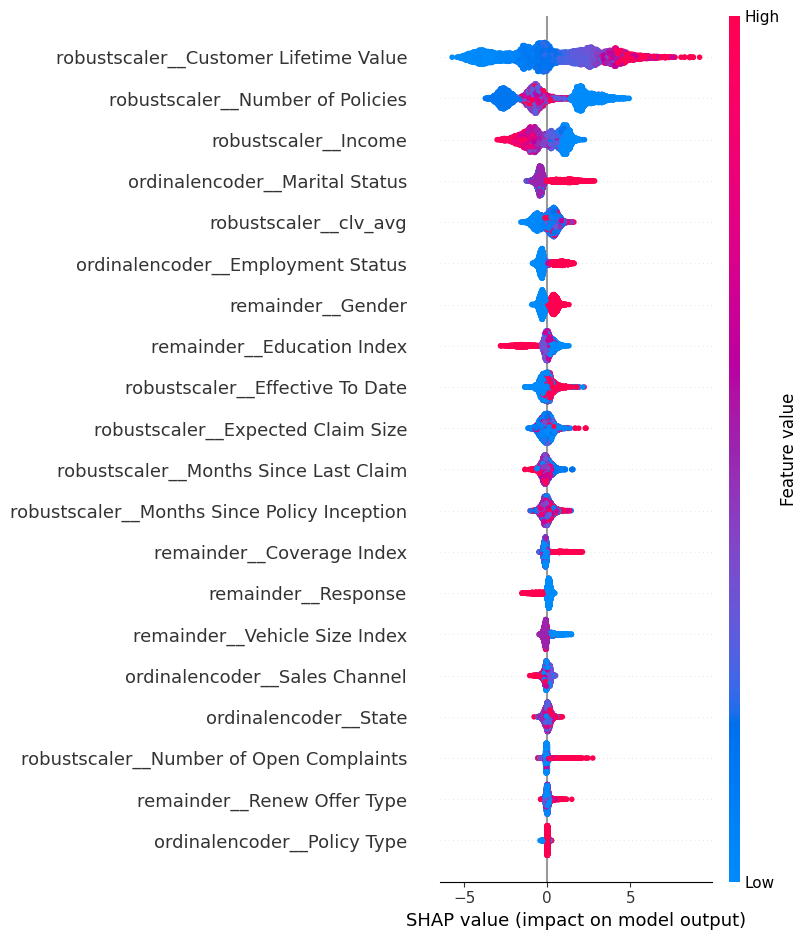

In [411]:
# Shap summary plot
shap.summary_plot(shap_vals, X_transformed, feature_names = tree_preprocessor.get_feature_names_out())

### Get Submission

In [412]:
# Predict on test set
model = make_pipeline(tree_preprocessor, LGBMClassifier())
model.fit(X, y)
y_pred = model.predict(X_test)
y_pred

/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 832, number of negative: 6458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1270
[LightGBM] [Info] Number of data points in the train set: 7290, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.114129 -> initscore=-2.049243
[LightGBM] [Info] Start training from score -2.049243


/Users/tung/Repos/auto-insurance-claim-prediction/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0])

In [413]:
# Create submission
pred = pd.Series(y_pred, name = 'Claim over 1k')
submission = pd.concat([df_test['CustomerID'], pred], axis = 1)
submission.to_csv(SUBMISSION_PATH, index = False)